In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('bmh')
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = 14
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.model_selection as ms
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
boston = pd.read_csv('bostonhousing.csv')
boston.head()

ID     crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0   1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1   2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2   3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3   4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4   5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   

   ptratio   black  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [3]:
def splitting(a,b,target):
    split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for training_indices, test_indices in split.split(a, b):
        stratified_train_set = a.loc[training_indices]
        stratified_test_set = a.loc[test_indices]
        fea_train, lab_train = (stratified_train_set.drop(target, axis = 1), stratified_train_set[target[0]].copy())
        fea_test, lab_test = (stratified_test_set.drop(target, axis = 1), stratified_test_set[target[0]].copy())
    return stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test
def catnum(features, col):
    num, cat = (fea_train.drop(col, axis = 1), fea_train[col])
    return num, cat
def meanerror(a,b):
    print('(meansquareerror, r2score) = ' , (np.sqrt(mean_squared_error(a,b)), r2_score(a,b)))
def crossval(reg, data_tr, labels):
    scores = cross_val_score(reg, data_tr, labels, scoring='neg_mean_squared_error', cv=10)
    sq_scores = np.sqrt(-scores)
    print('(cross_val_mean, cross_val_std) = ' , (sq_scores.mean(), sq_scores.std()))

In [4]:
lstat1 = boston['lstat'] // 5.5

In [5]:
lstat1.unique()

array([ 0.,  1.,  2.,  3.,  5.,  4.,  6.])

In [6]:
boston.groupby(lstat1).size()

lstat
0.0     78
1.0    168
2.0    127
3.0     77
4.0     33
5.0     17
6.0      6
dtype: int64

In [7]:
lstat1[lstat1 >= 4] = 4

In [8]:
boston.groupby(lstat1).size()

lstat
0.0     78
1.0    168
2.0    127
3.0     77
4.0     56
dtype: int64

In [9]:
stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test = splitting(boston, lstat1, ['medv'])

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column_names].values

In [11]:
%run 'CategoricalEncoder.py'

In [12]:
num_col, cat_col = catnum(fea_train, ['chas'])
numeric_cols = list(num_col)
categorical_cols = ['chas']

In [13]:
numeric_cols_pipeline = Pipeline([('selector', ColumnSelector(list(num_col))),
                                    ('standard_scaler', StandardScaler())
                                 ])

In [14]:
categorical_cols_pipeline = Pipeline([('selector', ColumnSelector(categorical_cols)),
                                      ('encoder', CategoricalEncoder(encoding='onehot-dense'))
                                     ])
full_pipeline = FeatureUnion(transformer_list=[('numeric_pipeline', numeric_cols_pipeline),
                                               ('categorical_pipeline', categorical_cols_pipeline)])

In [15]:
boston_transformed = full_pipeline.fit_transform(stratified_train_set)
boston_transformed.shape
boston_transformed

(404, 15)

array([[ 0.65714344, -0.41442674,  1.22033405, ..., -0.93904963,
         1.        ,  0.        ],
       [ 1.61640458, -0.40447334, -0.50274138, ...,  0.73635294,
         1.        ,  0.        ],
       [-0.44114106, -0.41167568,  1.43571848, ..., -1.37038257,
         1.        ,  0.        ],
       ..., 
       [ 1.53299057,  0.12494139, -0.50274138, ...,  0.82234214,
         1.        ,  0.        ],
       [-1.31003703, -0.41490002,  0.03571969, ..., -0.64502202,
         1.        ,  0.        ],
       [-0.51065274, -0.41118333, -0.50274138, ..., -1.09993265,
         1.        ,  0.        ]])

In [16]:
actual = list(lab_train)

In [17]:
from pyearth import Earth

In [18]:
mars = Earth()
x = mars.fit(boston_transformed, lab_train)
y = mars.predict(boston_transformed)
meanerror(actual,y)
crossval(mars, boston_transformed, lab_train)

(meansquareerror, r2score) =  (3.3078514834035175, 0.87024193101844793)
(cross_val_mean, cross_val_std) =  (3.9351239627111432, 0.87524298159538627)


In [19]:
import seaborn as sns

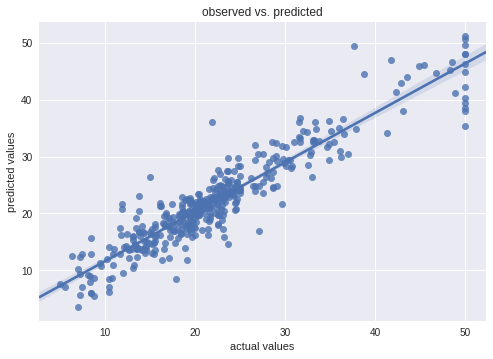

In [20]:
actual1= np.asarray(actual)
plt.figure()
df = pd.DataFrame({'observed' : actual1, 'predicted' : y})
x = sns.regplot(actual1, y, df)
plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("observed vs. predicted")
plt.show()

In [21]:
residual = actual - y
plt.figure()
df = pd.DataFrame({ 'predicted' : y, 'residuals' : residual})
x = sns.regplot( y, residual,  df)
plt.xlabel("predicted")
plt.ylabel("residuals")
plt.title(" predicted vs. residuals")
plt.show()

In [23]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = [
        {'max_terms': range(1, 15), 'max_degree': range(1, 15)},
    ]
mars2 = Earth()
grid_search = GridSearchCV(mars2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs = 4)
x = grid_search.fit(boston_transformed, lab_train)
grid_search.best_params_

{'max_degree': 2, 'max_terms': 14}

In [34]:
final_model = grid_search.best_estimator_
boston_transformed = full_pipeline.transform(fea_train)
predictions = final_model.predict(boston_transformed)
meanerror(lab_train,predictions)
crossval(mars2, boston_transformed, lab_train)

(meansquareerror, r2score) =  (3.0113224401119498, 0.89246325413422245)
(cross_val_mean, cross_val_std) =  (3.9351239627111432, 0.87524298159538627)
